# GAN_MNIST
This code below is all about Generative Adversarial Network (GAN Model) to generate images which are similar to MNIST datasets. It demonstrates GAN model code simulation.
I make GAN models to generate MNIST dataset.

One model has batch normalization layers and this is initialized with Xavier, He initialization. In related paper, Directly applying batchnorm to all layers resulted in sample oscillation and model instability. Therefore, this was avoided by not applying batchnorm to the generator output layer and the discriminator input layer. 

Therefore, I adopted this opinion and make a code like this way.


## Import header

In [1]:
import os
import torch
import torch.nn             as nn
import torch.optim          as optim
import torchvision
import torchvision.datasets as dsets
from   torch.utils.data       import DataLoader
from   torchvision.transforms import transforms
from   torchvision.utils      import save_image

## Select Cuda or CPU

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device: {}'.format(device))

device: cuda


## Give a seed

In [3]:
torch.manual_seed(777)
if device=='cuda':
    torch.cuda.manual_seed_all(777)

## Hyper parameters

In [4]:
image_size = 784 
hidden_size = 256
latent_code_size = 64
batch_size = 100 
total_epoch = 200
sample_dir= 'fake_images/3_Init&BN_Init'

if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

## Dataset

In [5]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                                     std=[0.5])
])
MNIST_train = dsets.MNIST(root = 'MNIST_data/', train=True,  transform=transform, download=True)
MNIST_test  = dsets.MNIST(root = 'MNIST_data/', train=False, transform=transform, download=True)

dataloader = DataLoader(dataset=MNIST_train, batch_size = batch_size, drop_last=True, shuffle=True)
iteration = len(dataloader)
print('iteration: {}'.format(iteration))

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw

iteration: 600


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Model

In [6]:
class Binary_Classfier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(image_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size,1)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()
        nn.init.kaiming_normal_(self.linear1.weight, a=0.2, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.kaiming_normal_(self.linear2.weight, a=0.2, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.xavier_normal_(self.linear3.weight)

    def forward(self, x):
        out = self.linear1(x)
        out = self.LeakyReLU(out)
        
        out = self.linear2(out)
        out = self.LeakyReLU(out)

        out = self.linear3(out)
        out = self.sigmoid(out)
        return out

class GAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(latent_code_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size,image_size)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.tanh = nn.Tanh()

        nn.init.kaiming_normal_(self.linear1.weight, a=0.2, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.kaiming_normal_(self.linear2.weight, a=0.2, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.xavier_normal_(self.linear3.weight)

    def forward(self,x):
        out = self.linear1(x)
        out = self.LeakyReLU(out)
        
        out = self.linear2(out)
        out = self.LeakyReLU(out)

        out = self.linear3(out)
        out = self.tanh(out)
        return out

BC_model = Binary_Classfier().to(device)
GAN_model = GAN().to(device)

In [7]:
class Binary_Classfier_He(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(image_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size,1)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.batch_norm3 = nn.BatchNorm1d(1)

        nn.init.kaiming_normal_(self.linear1.weight, a=0.2, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.kaiming_normal_(self.linear2.weight, a=0.2, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.xavier_normal_(self.linear3.weight)

    def forward(self, x):
        out = self.linear1(x)
        out = self.LeakyReLU(out)
        
        out = self.linear2(out)
        out = self.batch_norm2(out)
        out = self.LeakyReLU(out)

        out = self.linear3(out)
        out = self.batch_norm3(out)
        out = self.sigmoid(out)
        return out

class GAN_He(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(latent_code_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size,image_size)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.tanh = nn.Tanh()
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.batch_norm3 = nn.BatchNorm1d(image_size)

        nn.init.kaiming_normal_(self.linear1.weight, a=0.2, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.kaiming_normal_(self.linear2.weight, a=0.2, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.xavier_normal_(self.linear3.weight)

    def forward(self,x):
        out = self.linear1(x)
        out = self.batch_norm1(out)
        out = self.LeakyReLU(out)
        
        out = self.linear2(out)
        out = self.batch_norm2(out)
        out = self.LeakyReLU(out)
        
        out = self.linear3(out)
        out = self.tanh(out)
        return out

BC_model_He = Binary_Classfier_He().to(device)
GAN_model_He = GAN_He().to(device)

In [8]:
criterion = nn.BCELoss().to(device)
BC_optimizer = optim.Adam(BC_model.parameters(), lr=0.0002)
GAN_optimizer = optim.Adam(GAN_model.parameters(), lr=0.0002)
BC_optimizer_He = optim.Adam(BC_model_He.parameters(), lr = 0.0002)
GAN_optimizer_He = optim.Adam(GAN_model_He.parameters(), lr=0.0002)

## Training

In [9]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [10]:
D_loss_array = list()
G_loss_array = list()
D_loss_array_He = list()
G_loss_array_He = list()

for epoch in range(total_epoch):
    BC_model_He.train()
    GAN_model_He.train()

    BC_model.train()
    GAN_model.train()

    D_average_loss = 0.
    G_average_loss = 0.

    D_average_loss_He = 0.
    G_average_loss_He = 0.

    for (images,_) in (dataloader):
        ### print(images.shape)
        images = images.reshape(batch_size, -1).to(device)
        ### print(images.shape)

        # Discriminator
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        ### print(real_labels.shape)
        ### print(fake_labels.shape)

        # Generator
        z = torch.randn(batch_size, latent_code_size).to(device)
        ### print('latent code z shape: {}'.format(z.shape))

        GAN_model_He.eval()
        GAN_model.eval()
        D_score = BC_model(images)
        D_score_He = BC_model_He(images)

        fake_images = GAN_model(z)
        G_score = BC_model(fake_images)
        fake_images_He = GAN_model_He(z)
        G_score_He = BC_model_He(fake_images_He)
        
        ### Discriminator loss and update parameters
        D_loss = criterion(D_score,real_labels) + criterion(G_score, fake_labels)
        BC_optimizer.zero_grad()
        GAN_optimizer.zero_grad()
        D_loss.backward(retain_graph=True)
        BC_optimizer.step()

        D_loss_He = criterion(D_score_He,real_labels) + criterion(G_score_He, fake_labels)
        BC_optimizer_He.zero_grad()
        GAN_optimizer_He.zero_grad()
        D_loss_He.backward(retain_graph=True)
        BC_optimizer_He.step()

        BC_model_He.eval()
        BC_model.eval()

        GAN_model_He.train()
        GAN_model.train()

        z = torch.randn(batch_size, latent_code_size).to(device)
        fake_images = GAN_model(z)
        G_score = BC_model(fake_images)
        fake_images_He = GAN_model_He(z)
        G_score_He = BC_model_He(fake_images_He)

        # Fix Discrimnator's parameters and update Generator's parameters only.
        # Update parameters of Generator.
        G_loss = criterion(G_score, real_labels)
        GAN_optimizer.zero_grad()
        BC_optimizer.zero_grad()
        G_loss.backward()
        GAN_optimizer.step()

        G_loss_He = criterion(G_score_He, real_labels)
        GAN_optimizer_He.zero_grad()
        BC_optimizer_He.zero_grad()
        G_loss_He.backward()
        GAN_optimizer_He.step()

        # Calculate average losse of Discriminator and Generator during one epoch.
        D_average_loss += D_loss/iteration
        G_average_loss += G_loss/iteration
        
        D_average_loss_He += D_loss_He/iteration
        G_average_loss_He += G_loss_He/iteration

    print('Epoch: {:4d}/{} D_Loss:      {:.5f} G_Loss:      {:.5f} D_score:      {:.5f} G_score:      {:.5f}'.format(epoch, total_epoch, D_average_loss, G_average_loss, D_score.float().mean().item(), G_score.float().mean().item()))
    print('Epoch: {:4d}/{} D_Loss_norm: {:.5f} G_Loss_norm: {:.5f} D_score_norm: {:.5f} G_score_norm: {:.5f}'.format(epoch, total_epoch, D_average_loss_He, G_average_loss_He, D_score_He.float().mean().item(), G_score_He.float().mean().item()))
    print('=================================================================================================')
    D_loss_array.append(D_average_loss.tolist())
    G_loss_array.append(G_average_loss.tolist())

    D_loss_array_He.append(D_average_loss_He.tolist())
    G_loss_array_He.append(G_average_loss_He.tolist())


    # Save real images
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    
    # Save sampled images
    if ((epoch+1)%25==0 or epoch==0):
        fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
        save_image(denorm(fake_images), os.path .join(sample_dir, 'fake_images_Init-{}.png'.format(epoch)))

        fake_images_He = fake_images_He.reshape(fake_images_He.size(0), 1, 28, 28)
        save_image(denorm(fake_images_He), os.path.join(sample_dir, 'fake_images_Init_BN-{}.png'.format(epoch)))

# Save the model checkpoints 
torch.save(GAN_model.state_dict(), 'GAN_model.ckpt')
torch.save(BC_model.state_dict(), 'BC_model.ckpt')
torch.save(GAN_model_He.state_dict(), 'GAN_model_He.ckpt')
torch.save(BC_model_He.state_dict(), 'BC_model_He.ckpt')


Epoch:    0/200 D_Loss:      0.16000 G_Loss:      4.62863 D_score:      0.99659 G_score:      0.00548
Epoch:    0/200 D_Loss_norm: 0.12803 G_Loss_norm: 4.73845 D_score_norm: 0.99330 G_score_norm: 0.01295
Epoch:    1/200 D_Loss:      0.02172 G_Loss:      6.73128 D_score:      0.98461 G_score:      0.01269
Epoch:    1/200 D_Loss_norm: 0.07114 G_Loss_norm: 5.68137 D_score_norm: 0.96199 G_score_norm: 0.03516
Epoch:    2/200 D_Loss:      0.02632 G_Loss:      8.99612 D_score:      0.99296 G_score:      0.01090
Epoch:    2/200 D_Loss_norm: 0.17738 G_Loss_norm: 4.67221 D_score_norm: 0.96740 G_score_norm: 0.05270
Epoch:    3/200 D_Loss:      0.11456 G_Loss:      11.59873 D_score:      0.83009 G_score:      0.01076
Epoch:    3/200 D_Loss_norm: 0.26480 G_Loss_norm: 4.21578 D_score_norm: 0.91218 G_score_norm: 0.06781
Epoch:    4/200 D_Loss:      0.19267 G_Loss:      7.73107 D_score:      0.82069 G_score:      0.09239
Epoch:    4/200 D_Loss_norm: 0.41739 G_Loss_norm: 3.52069 D_score_norm: 0.81550 G

## Download image file from Colab

In [11]:
from google.colab import files

files.download('/content/fake_images/3_Init&BN_Init/fake_images_Init-0.png')
files.download('/content/fake_images/3_Init&BN_Init/fake_images_Init-24.png')
files.download('/content/fake_images/3_Init&BN_Init/fake_images_Init-49.png')
files.download('/content/fake_images/3_Init&BN_Init/fake_images_Init-74.png')
files.download('/content/fake_images/3_Init&BN_Init/fake_images_Init-99.png')
files.download('/content/fake_images/3_Init&BN_Init/fake_images_Init-124.png')
files.download('/content/fake_images/3_Init&BN_Init/fake_images_Init-149.png')
files.download('/content/fake_images/3_Init&BN_Init/fake_images_Init-174.png')
files.download('/content/fake_images/3_Init&BN_Init/fake_images_Init-199.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
files.download('/content/fake_images/3_Init&BN_Init/fake_images_Init_BN-0.png')
files.download('/content/fake_images/3_Init&BN_Init/fake_images_Init_BN-24.png')
files.download('/content/fake_images/3_Init&BN_Init/fake_images_Init_BN-49.png')
files.download('/content/fake_images/3_Init&BN_Init/fake_images_Init_BN-74.png')
files.download('/content/fake_images/3_Init&BN_Init/fake_images_Init_BN-99.png')
files.download('/content/fake_images/3_Init&BN_Init/fake_images_Init_BN-124.png')
files.download('/content/fake_images/3_Init&BN_Init/fake_images_Init_BN-149.png')
files.download('/content/fake_images/3_Init&BN_Init/fake_images_Init_BN-174.png')
files.download('/content/fake_images/3_Init&BN_Init/fake_images_Init_BN-199.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
import matplotlib.pyplot as plt

%matplotlib inline

def plot_compare(loss_list_origin: list, loss_list_he, ylim=None, title=None) -> None:
    plt.figure(figsize=(15, 10))
    plt.plot(loss_list_origin, label='init')
    plt.plot(loss_list_he, label='init & batch')
    if ylim:
        plt.ylim(ylim)

    if title:
        plt.title(title)
    plt.legend()
    plt.grid('on')
    plt.show()

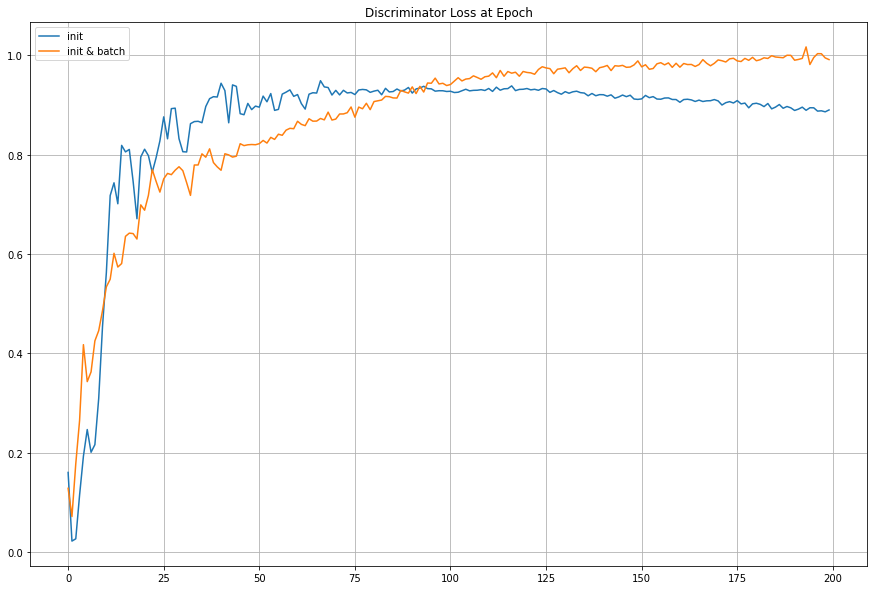

In [14]:
plot_compare(D_loss_array,D_loss_array_He, title='Discriminator Loss at Epoch')

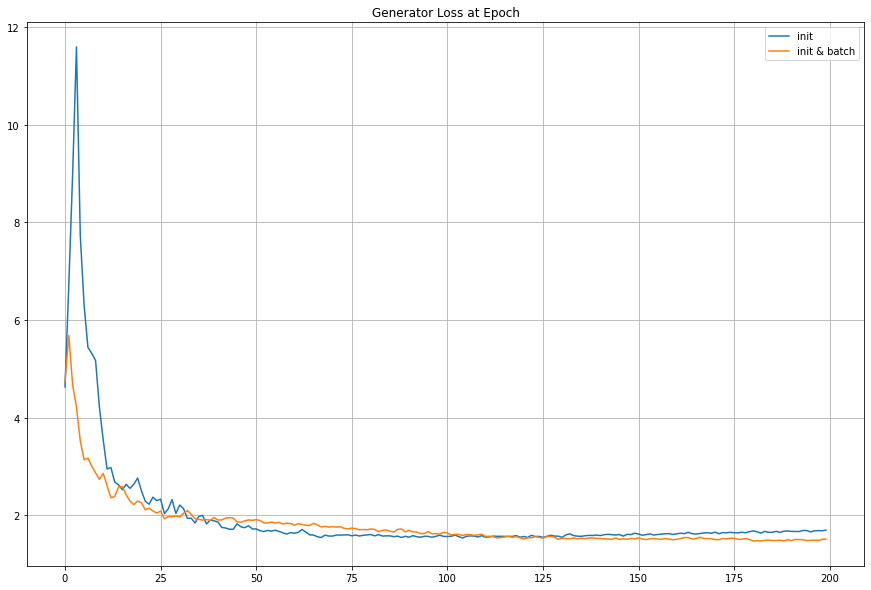

In [15]:
plot_compare(G_loss_array,G_loss_array_He, title='Generator Loss at Epoch')